<a href="https://colab.research.google.com/github/RAJESHVELAMALA/Project3/blob/main/ImageProcessingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from PIL import Image
import pandas as pd
import requests
import numpy as np
import pickle


In [ ]:
def loadImages(path, filename):
  print("Loading images...")
  print("Reading the meta file containing all image file names")
  filenames_df = pd.read_csv(path+filename)
  base_path = path + "Faces/"
  print(filenames_df.shape)
 # Create a empty list to hold images
  images = []
  filenames_df_success = []

  # Sort Dataset on id
  filenames_df = filenames_df.sort_values(by=['id'])
  for i in range(len(filenames_df)):
      filename = filenames_df.iloc[i,0]
      path = base_path + filename
      #print(f'{i} of {len(filenames_df)}: Attempting to import {path}')
      try:
          images.append(Image.open(path))
          filenames_df_success.append(filename)
      except:
          print(f'FAILED: {filename}')
  print(len(filenames_df_success))
  print("Images loaded!" + str(len(images)))
  return (images,filenames_df_success)

In [ ]:
def createPickle(images):
  print("Creating pickle file...")
  with open('/content/drive/My Drive/imgages_project3.pkl', 'wb') as file:
      pickle.dump(images, file)
      print("Pickle file created!")

In [ ]:
def createPickleDF(filenames):
  print("Creating pickle file...")
  filenames_df = pd.DataFrame(filenames)
  pd.to_pickle(filenames_df, '/content/drive/My Drive/filenames_df_project3.pkl')
  print("Pickle file created!")


In [ ]:
imageList,fileNameList = loadImages("/content/sample_data/", "Dataset.csv")
createPickle(imageList)
createPickleDF(fileNameList)

Loading images...
Reading the meta file containing all image file names
(2562, 2)
FAILED: Akshay Kumar_0.jpg
FAILED: Akshay Kumar_1.jpg
FAILED: Akshay Kumar_10.jpg
FAILED: Akshay Kumar_11.jpg
FAILED: Akshay Kumar_12.jpg
FAILED: Akshay Kumar_13.jpg
FAILED: Akshay Kumar_14.jpg
FAILED: Akshay Kumar_15.jpg
FAILED: Akshay Kumar_16.jpg
FAILED: Akshay Kumar_17.jpg
FAILED: Akshay Kumar_18.jpg
FAILED: Akshay Kumar_19.jpg
FAILED: Akshay Kumar_2.jpg
FAILED: Akshay Kumar_20.jpg
FAILED: Akshay Kumar_21.jpg
FAILED: Akshay Kumar_22.jpg
FAILED: Akshay Kumar_23.jpg
FAILED: Akshay Kumar_24.jpg
FAILED: Akshay Kumar_25.jpg
FAILED: Akshay Kumar_26.jpg
FAILED: Akshay Kumar_27.jpg
FAILED: Akshay Kumar_28.jpg
FAILED: Akshay Kumar_29.jpg
FAILED: Akshay Kumar_3.jpg
FAILED: Akshay Kumar_30.jpg
FAILED: Akshay Kumar_31.jpg
FAILED: Akshay Kumar_32.jpg
FAILED: Akshay Kumar_33.jpg
FAILED: Akshay Kumar_34.jpg
FAILED: Akshay Kumar_35.jpg
FAILED: Akshay Kumar_36.jpg
FAILED: Akshay Kumar_37.jpg
FAILED: Akshay Kumar_38.jp

In [1]:
def loadImagesFromPickle():
  # Mount google drive
  from google.colab import drive
  drive.mount('/content/drive')
  print("Loading images from pickle file...")
  with open('/content/drive/My Drive/imgages_project3.pkl', 'rb') as file:
      images = pickle.load(file)
  return images

In [2]:
def loadFilenamesFromPickle():
  from google.colab import drive
  drive.mount('/content/drive')

  print("Loading filenames from pickle file...")
  filenames_df = pd.read_pickle('/content/drive/My Drive/filenames_df_project3.pkl')
  return filenames_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading images from pickle file...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading filenames from pickle file...
Alia Bhatt_4.jpg


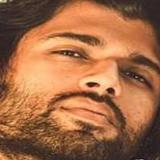

In [5]:
faceImages = loadImagesFromPickle()
filenames = loadFilenamesFromPickle()

filenames_df = pd.DataFrame(filenames)

#Print first row from dataframe
print(filenames_df.iloc[1,0])
faceImages[23]


In [6]:
sizes = set([img.size for img in faceImages])
sizes


{(160, 160)}

In [7]:
def preProcessImages(imageList):
  print("Preprocessing images...")
  # Resize images
  target_size = (160, 160)
  resized_images = [img.resize(target_size, resample = Image.LANCZOS) for img in faceImages]

  # Convert all images to floating point numpy arrays
  float_images = [np.array(img).astype(np.float32) for img in resized_images]

  # To normalize images to a range between 0 and 1,
  # we need to divide all pixel values by the max of 255

  normalized_images = [img/255 for img in float_images]

  # Display the pixel values of the first image
  #print(normalized_images[0])

  return normalized_images

In [128]:
normalized_images = preProcessImages(faceImages)
#

Preprocessing images...


In [8]:
# Now we can call our preprocessed pixel data 'X'
X = preProcessImages(faceImages)

# For our purposes, we'll select the userid column as 'y'
y = np.array(filenames_df[0])

Preprocessing images...


In [9]:
filenames_df.columns

RangeIndex(start=0, stop=1, step=1)

In [10]:
print(len(X))
print(len(y))

24
24


In [11]:
# Now we'll split our data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [13]:
def enhanceDataSetForAugmentation(X_train,y_train):
  # Apply augmentation to the whole training dataset
  # Create an ImageDataGenerator
  datagen = ImageDataGenerator(
      rotation_range=20,      # Random rotation (degrees)
      width_shift_range=0.1,  # Random horizontal shift
      height_shift_range=0.1, # Random vertical shift
      shear_range=0.2,        # Shear intensity
      zoom_range=0.2,         # Random zoom
      horizontal_flip=True,   # Random horizontal flip
      vertical_flip=False,    # No vertical flip for face images
      fill_mode='nearest'     # Fill mode for handling newly created pixels
  )

  # Create variables to hold the X and y training data
  X_train_aug = []
  y_train_aug = []
  # Loop through all the images.
  for i in range(len(X_train)):
      # Select the image
      img = X_train[i]
      # Select the label from the training data
      label = y_train[i]

      # Add a channel dimension for grayscale images if needed
      if img.ndim == 2:  # Check if it's grayscale (2 dimensions)
          img = np.expand_dims(img, axis=-1)  # Add channel dimension

      # Ensure that the input data has the correct shape (remove extra dimension)
      # img = np.squeeze(img, axis=-1)  # Remove the extra dimension - Not needed anymore

      # Add 5 images for every original image
      for j in range(5):
          # Append a new image to the X list
          X_train_aug.append(next(datagen.flow(np.expand_dims(img, axis=0), batch_size=1))[0]) # Use next() to get the next item from the iterator
          # Append the label for the original image to the y list - replicate the label for each augmented image
          y_train_aug.append(label)

  return X_train_aug, y_train_aug

In [14]:
X_train_aug, y_train_aug = enhanceDataSetForAugmentation(X_train,y_train)

# Print the length of each list
print(len(X_train_aug))
print(len(y_train_aug))

90
90


In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# One hot encode the y data
y_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(np.array(y_train_aug).reshape(-1, 1))
y_train_aug_enc = y_encoder.transform(np.array(y_train_aug).reshape(-1, 1))
y_test_enc = y_encoder.transform(np.array(y_test).reshape(-1, 1))

# Convert values to numpy arrays
X_train_aug_np = np.array(X_train_aug)
#X_test_np = np.array(X_test_np)
y_train_aug_np = np.array(y_train_aug_enc)
#y_test_np = np.array(y_test_enc)

# Load and preprocess your CMU Face Images dataset (Ensure each image is labeled as "with sunglasses" or "without sunglasses")
# The following code assumes that you have already loaded and preprocessed your dataset into 'X' and 'y' (features and labels).

# Split the training dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_aug_np, y_train_aug_np, test_size=0.2, random_state=42)

# Print the total number of one_hot_encoded columns
np.array(y_train).shape

(72, 18)

In [17]:
# Define a CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(18, activation='sigmoid')  # Change to 18 classes to match your labels
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 13
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/13
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.0885 - loss: 3.7299 - val_accuracy: 0.0000e+00 - val_loss: 3.2136
Epoch 2/13
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.0768 - loss: 3.1710 - val_accuracy: 0.1111 - val_loss: 2.8643
Epoch 3/13
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.0543 - loss: 2.8669 - val_accuracy: 0.2222 - val_loss: 2.7977
Epoch 4/13
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.1940 - loss: 2.7388 - val_accuracy: 0.1667 - val_loss: 2.6008
Epoch 5/13
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2943 - loss: 2.5645 - val_accuracy: 0.2778 - val_loss: 2.4219
Epoch 6/13
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 976ms/step - accuracy: 0.4015 - loss: 2.3480 - val_accuracy: 0.1667 - val_loss: 2.2487
Epoch 7/13
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3438 - loss: 2.1559 - val_accuracy: 0.2778 - val_loss: 2.1255
Epoch 8/13
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4449 - loss: 1.8591 - val_accuracy: 0.3889 - val_loss: 1.6952
Epoch 9/1

In [18]:
print(X_test_np.shape)
print(y_test_np.shape)
print(X_train.shape)
print(y_train.shape)


NameError: name 'X_test_np' is not defined

In [20]:
# Reshape test data for the model
X_test_np = []
for img in X_test:
    # Add a channel dimension for grayscale images
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    # Append the image to the list
    X_test_np.append(img)

# Convert to numpy array **and specify the shape**
X_test_np = np.array(X_test_np, dtype=np.float32).reshape(-1, 160, 160, 1) # Assuming your images are 160x160
y_test_np = np.array(y_test_enc)

# Check the shape of the first image
print(X_test_np[0].shape)

# Check if the number of samples in X_test_np and y_test_np match
print("Number of samples in X_test_np:", X_test_np.shape[0])
print("Number of samples in y_test_np:", y_test_np.shape[0])

# If the numbers don't match, investigate why there's a difference.
# You might need to adjust how you preprocessed or split your data.

# Once the number of samples match, you can evaluate the model:
if X_test_np.shape[0] == y_test_np.shape[0]:
    model.evaluate(X_test_np, y_test_np)
else:
    print("Error: Number of samples in X_test_np and y_test_np don't match. Cannot evaluate the model.")

(160, 160, 1)
Number of samples in X_test_np: 18
Number of samples in y_test_np: 6
Error: Number of samples in X_test_np and y_test_np don't match. Cannot evaluate the model.


In [117]:
model.evaluate(X_test_np, y_test_np)

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None